<a href="https://colab.research.google.com/github/antonFJohansson/Article_collection/blob/master/Bayesian_Learning_via_Stochastic_Gradient_Langevin_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------
We want to obtain samples from the posterior distribution. This can be done with an MCMC scheme but the main issue then is that the entire data set needs to be processed at each iteration, the goal of the article is combine stochastic optimization and sampling from the posterior distribution such that we can work with mini-batches.

In Robbins-Monreo optimization (mini-batch optimization we calculate the following gradient)
$$\Delta \theta_t = \frac{\epsilon_t}{2}\bigg(\Delta \log p(\theta_t) + \frac{N}{n}\sum_{i=1}^n\Delta \log p(x_{ti}|\theta_t)\bigg)$$
Where $x_{ti}$ is sample $i$ from minibatch $t$, $\epsilon_t$ is the step-sizes [Q1].

We require that the step-sizes fulfill
$$\sum_{t=1}^{\infty}\epsilon_t = \infty ~~~~\sum_{t=1}^{\infty}\epsilon_t^2 < \infty$$
in order for convergence to a local maximum. This is since they are argue that intuitively we need step-sizes to sum to infinity to be able to reach the maximum no matter how far away it is, and the quadratic sum should converge so that we can stay at the maximum and not bounce around it.
They say that they use the step-sizes given as $\epsilon_t = a(b+t)^{-\gamma}~~\gamma \in (0.5,1]$. In order for us to combine these methods we will implement a special class of MCMC routines, Langevin Dynamics.

## Questions/Answers
* [Q1] Why do we divide by 2 in the expression for the gradient? Just for ease of notation? Since it should not affect anything if we removed it?



--------------------------------------------
In Hamiltonian dynamics we can have a simple physical representation of the dynamics. This is given as the dynamics of a frictionless puck that slides over a surface of varying heights, it will have potential and kinetic energy. The state of the system is described by the **position** $q$ and **momentum** $p$. For non-physical interpretations of Hamiltonian dynamics we will have that the position variable will correspond to the variables of interest, the potential enery will be the log of the probabiltiy density. Momentum will be introduced artificially [Q2].

Hamiltonian dynamics will operate on a d-dimensional **position** vector $q$ and d-dimensional **momentum** vector p [Q3]. The system is described by the Hamiltonian $H(p,q)$. We have the equations given as (for $i=1,...,d$)
\begin{align}
\frac{dq_i}{dt} &= \frac{\partial H}{\partial p_i} \\
\frac{dp_i}{dt} &= -\frac{\partial H}{\partial q_i} 
\end{align}
This will thus describe the time-evolution of the system.

For Hamiltonian Monte Carlo, acommon way to write the Hamiltonian is given as
$$H(q,p) = U(q) + K(p)$$
$U$ is the potential energy and is often defined to be negative log probability of the distribution for $q$. $K$ is the kinetic energy and is often given as
$$K(p) = p^TM^{-1}p/2.$$
$M$ here is symmetric, positive-definite "mass-matrix" which is often a scalar multiple of the identity matrix. This form corresponds to a negative of the log probability density of a zero mean Gaussian for $p$ [Q4]. With these forms we can write the Hamiltonian equations as
\begin{align}
\frac{dq_i}{dt} &= [M^{-1}p]_i \\
\frac{dp_i}{dt} &= -\frac{\partial U}{\partial q_i} 
\end{align}

Some properties are crucial of the Hamiltonain dynamics in order to construct an MCMC scheme, these are [Q5]
* Reversibility: This is needed for the MCMC updates to leave the distribution invariant, which we show by reversibility of the Markov Chain transitions, which in turn is implied by the reversibility of the dynamics we use to propose the states.
* Hamiltonian is conserved: This means that $d H/dt = 0$, i.e $H$ will be constant throughout time. With a physics interpretation this can easily be understood as the conservation of energy. This is needed since the acceptance probability will be 1 if $H$ is invariant.
* Volume preserving: If we apply the solution $T_s$ to the differential equation to some points ($p,q$) in a region $R$ with volume $V$, then the volume of the area $R$ under $T_s$ will also be $V$. This is important in the MCMC scheme since we do not need to take into account any changes in the volume when we create the proposals and acceptance probabilties.

In order to actually work with these dynamics we need to approximate/solve the differential equation. This can be done with different methods, if one uses Euler's method one gets the equations
\begin{align}
p_i(t+\epsilon) &= p_i(t) + \epsilon \frac{dp_i}{dt}(t) = p_i(t) - \epsilon \frac{\partial U}{\partial q_i}(q(t)) \\
q_i(t+\epsilon) &= q_i(t) + \epsilon \frac{dq_i}{dt}(t) = q_i(t) - \epsilon \frac{p_i(t)}{m_i} 
\end{align}
where we have assumed $K(p) = \sum_{i=1}^d\frac{p_i^2}{2m_i}$. Thus we can initialize the dynamics from some starting point and see how it evolves. Euler's method is not good though and easily diverges to infinity. This might be due that the given scheme does not preserve volume, we have that if we apply our $T_s$ to some region then that region will have grown larger with some parts going to infinity. We can obtain better results by using the obtained value of $p_i(t+\epsilon)$ in the second equation (or vice versa with $q$), this can be attributed to the fact that the second method preserves the volume since if we do perform the transformation in steps such as these, the transformation will be a shear transformation that preserves volume.

They obtain even better results when they use the **leapfrog** method, which defines the transition as
\begin{align}
p_i(t+\epsilon /2) &= p_i(t) - \epsilon / 2\frac{\partial U}{\partial q_i}(q(t))\\
q_i(t+\epsilon) &= q_i(t) + \epsilon\frac{p_i(t+\epsilon / 2)}{m_i} \\
p_i(t+\epsilon) &= p_i(t+\epsilon / 2)- \epsilon / 2\frac{\partial U}{\partial q_i}(q(t+\epsilon))
\end{align}
So similarly to before, we perform a step in one of the variables first, just that we do a half-step in the momentum variable. Since we perform it stepwise for the two variables, this is also a shear transform and thus preserves volume. It also works with other kinetic energy terms $K(p)$, and the method is symmetric [Q6].
## Questions/Answers
* [Q2] So if we can introduce momentum arbitrarily then I guess we control how efficiently we move across the space with these parameters?
* [Q3] They say earlier that the position is described by a 2d-dimensional vector but now we live in a d-dimensional space for there parameters?
* [Q4] So with this $K$ we have maybe said that we want to take normal steps, or some form of normal dynamics like we do in MCMC?
* [Q5] I do not see exactly why all of these holds but I guess that is not too important for now.
* [Q6] The leapfrog method is apparently also symmetric but I cannot see it straight away. Maybe not so important to show as of right now

---------------------------------------------
Now we want to connect these Hamiltonian Dynamics to MCMC. We relate the distribution we want to sample from to a potential energy function with the help of the concept of canonical distribution from statistical mechanics [Q7]. From an energy function $E(x)$ we can create a probabiltiy density function as
$$P(x) = \frac{1}{Z}\exp (-E(x)/T)$$
We are interested in the opposite way and thus solve for $E(x)$ with $T=1$ and get $E(x) = -\log P(x) -\log Z$ where $Z$ is a normalization constant. The Hamiltonian depends both on $p$ and $q$ and thus we get a joint distribution for the two terms as
$$P(q,p) = \frac{1}{Z}\exp (-H(q,p)/T)$$
(We see that if we simulate a trajectory along the Hamiltonian then we will move along a path of constant probability density [Q8]). With the Hamiltonian given as before with $H(q,p) = U(q) + K(p)$ we get thejoint density to factor into two parts, thus $q$ and $p$ are independent. If we are interested in the posterior distribution we will take $U(q) = -\log\big[ \pi (q)L(q|D)\big]$.

**Important note is that HMC can only sample from continuous distributions on $\mathbb{R}^d$**. The HMC algorithm will sample from the joint posterior above, if we choose a quadratic kinetic energy term as $K(p) = p^TM^{-1}p/2$, this will correspond to a distribution on $p$ that is multivariate Gaussian. The parameter $m_i$ here can affect the performance of the algorithm. The algorithm consists of two steps
* The first step changes only the momentum: We first draw momentum variables from their Gaussian distributions independently of the values of the $q$/position variables (I guess we can see this as specifying a momentum for the puck irregardless of where the puck is). Now they argue that since $q$ isn't changed, and $p$ is drawn from the correct conditional distribution given $q$, the joint distribution will be invariant [Q9]. 
* In the second step we can change both the momentum and the position: We perform a Metropolis update where the new state is proposed with the help of Hamiltonian Dynamics. We start with the state $(q,p)$ and simulate the Hamiltonian Dynamics for $L$ steps with the leap frog method (other reversible methods that preserves volume also works) to get the state $(q*,p*)$. The new state is then accepted with probability
$$\min \big[1, \exp (-H(q*,p*) + H(p,q))\big]$$
(This last acceptance step comes form the Metropolis-Hastings algorithm where we want to sample from a distribution $P(x)$, propose with g(x|x^t) and get the acceptance probabilities as
$$\min \bigg(1, \frac{P(x')g(x_t|x')}{P(x)g(x'|x_t)}\bigg)$$
(we can see $x$ as a vector in the multivariable case). In our case we have that since we propose along paths of the Hamiltonian, the term $g(x_t|x')$ will cancel since the Hamiltonian moves along paths of constant probability density.) Thus we see that in HMC we only move to new density areaas in the first step when we propose a new value of $p$, in the second step we only move along curves of constant probability.[ But maybe this is a general idea to construct MCMC routines, that to sample the points in a smart way and one does not have to care about how these are actually proposed in order for the algorithm to be valid. [Q10]]


## Questions/Answers
* [Q7] Why do we need to relate it to a potential energy at all, we are working with abstract quantities so can we just not use the distribution straight away. Or is there concept which are needed such that it has to not change on level surfaces (no function does that though) or something similar that is fundamental to potential energy?
* [Q8] I presume that since we want to simulate from the Hamiltonian that we want to move along paths of constant probability, but why? It seems then that we will be stuck in such regions? Do we not want to explore all parts of the probability density?
* [Q9] What I presume they mean by invariant here is that after this step we are still targeting the correct joint distribution? I guess there could be algorithms where one slightly changes the target distribution that one samples from in the end with the goal that at infinity they would reconcile.I guess the important part is that we will still get samples from the correct distribution.
* [Q10] It feels like we shouldn't have to care too much about the proposal step but why is it then that they need to have all of these properties of the Hamiltonian dynamics actually?

-----------------------------------
The Langevin method is a special case of HMC where the proposal trajectory consists of only a single leapfrog step. We proceed as before and sample a momentum $p$ and then propose new values $q*$ and $p*$ as
\begin{align}
q_i* &= q_i - \frac{\epsilon^2}{2}\frac{\partial U}{\partial q_i}(q) + \epsilon p_i\\
p_i* &= p_i - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}(q) - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}(q*)
\end{align}
This is obtained simply by taking one step in the HMC equations above. We get the acceptance probability as
$$\min  \big[ 1, \exp \big(-(U(q*)-U(q) - \frac{1}{2} \sum_i ((p_i*)^2 - p_i^2))\big)\big]$$
which also follows from how we have defined the Hamiltonian. LMC (Langevin Monte Carlo) is in general more inefficient than HMC since we take smaller steps and we move almost akin to a random walk. It is also possible to remove the momentum variables here and instead propose the $q_i*$ from a Gaussian distribution with mean(s) $q_i - \epsilon^2/2[\partial U /\partial q_i](q)$ and variance(s) $\epsilon^2$. It is possible to work with an approximate scheme here as well where we skip the accept-reject step after proposing the new variables. If we connect this back to the original paper we can see that the parameter updates are given as
$$\Delta \theta_t = \frac{\epsilon}{2}\bigg( \nabla \log p(\theta_t) + \sum_{i=1}^n \nabla \log p(x_i|\theta_t)\bigg) + \eta_t$$
where $\eta_t \sim \mathcal{N}(0,\epsilon)$. This is since the full term that we propose for a new $q_i*$ is given as
$$q_i* = q_i - \epsilon^2/2[\partial U /\partial q_i](q) + \eta_i$$
Thus the $\Delta \theta_t$ will be the last part of the statement and inserting the posterior distribution one get the desired expression. They mention here that it is possible to correct for the fact that we approximate without an accept reject step, but as long as $\epsilon \rightarrow 0$ then the rejection probability will go to 0 and the approximation will be correct. The reason we will use Langevin dynamics instead of HMC (which theoretically gives better samples and is more efficient) is due to the fact that only Langevin can easily be adapted for the mini batch setting.

So the way we do it is to use the stochastic gradient minibatch descent but just add a small noise term, this gives the update equation as
$$\Delta \theta_t = \frac{\epsilon_t}{2}\bigg(\nabla \log p(\theta_t) + \frac{N}{n}\sum_{i=1}^n\nabla \log p(x_{ti}|\theta_t)\bigg) + \eta_t$$
where $\eta_t \sim \mathcal{N}(0,\epsilon_t)$. They now write that this will allow us to average out the stochasticity in the gradients (by working with minibatches I assume) but also the MH rejection rate since that goes to 0 as $\epsilon_t \rightarrow 0$, **thus we can ignore the MH acceptance step which requires evaluation of the probabilities over the whole dataset**[Q11]. What we need to show now is that our method will converge to Langevin dynamics which we know will converge to the posterior distribution and thus we will get samples from the desired posterior.

## Questions/Answers
* [Q11] I do not understand why we need to calculate the acceptance step over the whole region actually?


-----------------------------------
We introduce the quantities
$$g(\theta) =  \nabla \log p(\theta_t) + \sum_{i=1}^n \nabla \log p(x_i|\theta_t)$$
and 
$$h_t(\theta) = \nabla \log p(\theta) + \frac{N}{n}\sum_{i=1}^n\nabla \log p(x_{ti}|\theta) - g(\theta)$$
The stochastic gradient at $\theta$ is thus given by $g(\theta) + h_t(\theta)$. $h_t(\theta)$ will be a zero mean random variable since the only random part is the sum where we minibatch. If we inspect the expectation of this expression we obtain
$$\mathbb{E}\bigg(\frac{N}{n}\sum_{i=1}^n\nabla \log p(x_{ti}|\theta)\bigg) = \frac{N}{n}\sum_{i=1}^n\mathbb{E}\bigg(\nabla \log p(x_{ti}|\theta)\bigg)$$
And if just focus on the expectation we have that (since we draw the minibatch samples uniformly from the total data set),
$$\mathbb{E}\bigg(\nabla \log p(x_{ti}|\theta)\bigg) = \sum_{j=1}^N\frac{1}{N}\nabla \log p(x_{j}|\theta)$$ and thuswe get that $h_t(\theta)$ has 0 mean. They also write that $h_t(\theta)$ has finite variance $V(\theta)$, this follows if we assume that the distribution has support at the given $x_{i}$ I believe, since otherwise it is just a finite sum. Thus we can express our update scheme as 
$$\Delta \theta_t = \frac{\epsilon_t}{2}(g(\theta_t) + h_t(\theta)) +\eta_t$$
In this expression we have two sources of noise, the injected one from the normal distribution and the one that arises due to the minibatching, the injected noise has variance $\epsilon_t$ and the minibatch one has variance $\epsilon^2/2^2V(\theta_t)$. We see that for large $t$ we have that $\epsilon \rightarrow 0$ and thus the injected noise will dominate the noise terms, thus the term will be effectively Langevin dynamics [Q12]. And since when $\epsilon \rightarrow 0$ we also get that the rejection probability goes to 0 and we get true samples from the scheme.

In order to see that the sequence of parameters $\theta_t$ converges to samples from the posterior distribution we will look at a subsequence of samples $\theta_{t_1},\theta_{t_2},...$ and if this sequence converges then the entire sequence must converge [Q13]. The proof proceeds as follows:
* Fix an $\epsilon_0$ such that $0 < \epsilon_0 \ll 1$, since the series diverges and the sum of squares converges we can find a subsequence such that $\sum_{t=t_s+1}^{t_{s+1}} \epsilon_t \rightarrow \epsilon_0$ as $s\rightarrow \infty$ [Q14]. Since the injected noise at each step is independent, for large enough $s$, the total injected noise $||\sum_{t=t_s+1}^{t_{s+1}}\eta_t||_2$ between steps $t_s$ and $t_{s+1}$ will be $O(\sqrt{\epsilon_0})$. This is (I assume here that the variance of the normal distribution is given by $\epsilon$ and not the standard deviation) since we know from above that the sum of subsequence $\epsilon_t$ converges to $\epsilon_0$. These terms describe the variance of the corresponding $\eta_t$ and thus we get the sum of $\eta$ to get a variance that is the sum of the variances since the terms are independent. Thus for large $s$ we have that the convergence of the $\epsilon$ sum is close to $\epsilon_0$ and thus we get that the total injected noise will be $O(\sqrt{\epsilon_o})$ [Q15].
* We now want to show that for these steps, the noise due to the minibatched gradient will be dominated by that of the injected noise. Since we chose $\epsilon_0 \ll 1$, we can take $||\theta_t - \theta_{t_s}||_2 \ll 1$ for $t$ between $t_s$ and $t_{s+1}$ [Q16]. Now assuming that $g$ varies smoothly (i.e. it is Lipschitz continuous) we obtain 
$$\sum_{t=t_s+1}^{t_{s+1}} \frac{\epsilon_t}{2}(g(\theta_t)+h_t(\theta_t)) = \frac{\epsilon_0}{2}g(\theta_{t_s}) + O(\epsilon_0) + \sum_{t=t_s+1}^{t_{s+1}} \frac{\epsilon_t}{2}h_t(\theta_t) = \frac{\epsilon_0}{2}g(\theta_{t_s}) + O(\epsilon_0)$$
[Q17]. Thus we see here that the total gradient is approximately equal to the exact gradient + some noise. Since we also knew that the injected noise was of the order $O(\sqrt{\epsilon_o})$ then the injected noise will dominate and this will approach Langevin Dynamics. This is since we have exactly the form of Langevin Dynamics with the extra noise from the minibatching, which will be negligible for large $t$. [I think that is an interesting argument maybe that we show that one noise source will dominate the other one and thus we know that the dynamics will follows that described by the dominating noise.]



## Questions/Answers
* [Q12] I sort of see why it would be Langevin Dynamics but we do not have Langevin Dynamics to the right posterior right? We will approach the minibatch version it seems to me and then I do not see how we would get smples from the true posterior. And why do we rewrite it with g and h?
* [Q13] Why is it that if a subsequence converges then the entire sequence must converge?
* [Q14] This is not completely clear but it must be the relation between that the first order terms diverge and the second order converge, but I am unsure how to show this.
* [Q15] I do not see the connection between the variance and the total injected noise sort of, I understand that the terms are centered around 0 and in the end have a variance of this order, but does that imply that the term is of the order $O(\sqrt{\epsilon_0})$? For me when we speak of $O$ we say that the term should be bounded by this term as $n$ grow large? Must be some sort of random $O$, since that boundedness will only occur in probability. I would understand it if they had written that the variance of the total injected noise is bounded by that quantity.
* [Q16] And here as well, I do not know how they can say that the norm of the difference of the $\theta$ will be much smaller than 1, in probability I guess it holds but not a.e I think? Or do they just choose that subsequence such that it holds? And do not care about any randomness sort of?
* [Q17] This is not completely clear how they prove this no. I assume expanding the sum and using the Lipschitz condition but I do not see exactly how.




---------------------------------------------------------
So the algorithm is general purpose and allows us to obtain samples from a wide variety of methods. In the beginning the minibatch noise will dominate and the method will follow stochastic gradient descent, towards the end the injected noise will dominate and we will have Langevin dynamics. One main issue is that we need to keep decreasing the step size in order for this transition to occur, which could slow down the optimization but also give very similar samples from the posterior. Their suggestion as remedies for this issue are:
* Fix the step-size beyond a certain point when the rejection-rate is negligible.
* Use the algorithm for burn-in and then switch to a more efficient MCMC scheme that makes use of the whole data later [Q18].

In order to actually work with this method though we need to keep a few things in mind:
* We should only start collecting samples after the Langevin Dynamics are dominating the behaviour.
* An idea of a rough estimate for how long until the method traverses the whole posterior [Q19].
* They use preconditioning here in order to speed up the method. Preconditioning transforms all dimensions to the same scale so that no gradient will dominate in any direction. The preconditioning is simply given as
$$\Delta \theta_t = \frac{\epsilon_t}{2}M\bigg(g(\theta_t) + h_t(\theta_t)\bigg) + \eta_t$$
where $\eta_t \sim \mathcal{N}(0, \epsilon_t M)$. 

In order to determine when the shift from stochastic optimization to Langevin Dynamics occur we can analyze this in the case for large minibatches. For large minibatches we have that the stochastic gradient will be accurately described by the central limit theorem. Thus the variations of $h_t(\theta_t)$ will become normally distributed around the true gradient $g(\theta_t)$ (which is the mean of the stochastic gradient terms) [This might be similar to what Hussein did when they showed that batchnorm is also a form of variational inference]. They then estimate the covariance matrix with the empirical covariance as
$$V(\theta_t) := V[h_t(\theta_t)] \approx \frac{N^2}{n^2}\sum_{i=1}^n(s_{ti}-\bar{s_t})(s_{ti}-\bar{s_t})^T$$
where $s_{ti} = \nabla \log p(x_{ti}|\theta_t) + \frac{1}{N}\nabla \log p(\theta_t)$ [Q20]. We can rewrite this as $V(\theta_t) = \frac{N^2}{n}V_s$, to see that it scales as $\frac{N^2}{n}$. From this we can thus see that the variance of the stochastic gradient step is given as
$$Var(\frac{\epsilon_t}{2}Mh_t(\theta_t)) = \frac{\epsilon_t^2N^2}{4n}MV_sM$$
Thus we are interested in controlling this term in all directions and therefore we want [Q21]
$$\frac{\epsilon_tN^2}{4n}\lambda_{max}(M^{\frac{1}{2}}V_sM^{\frac{1}{2}}) = \alpha \ll 1$$
I do not understand the final part before section 4.2


## Questions/Answers
* [Q18] Are there any issues with just switching MC method in the middle of this? Or can we do it without any bias or extra variance being introduced. I guess this is all just approximations so we would still get some approximate samples from the posterior.
* [Q19] But if we see this in a NN for example, the time taken must be massive?
* [Q20] I understand that we can do this for a given sample but are there any issue when we switch minibatch and obtain new samples? I do not know why there would be issues but maybe I just have not dealt with these situations before.
* [Q21] Why do we no longer look directly at the variance but instead the square root of some of the matrices etc? I understand we need to control it in all directions but where did the square root come from?

-------------------------------------------------------------------------------------
In order to estimate the posterior expectation of some function $f$, we can just use the sample average as usual and get the estimate
$\frac{1}{T}\sum_{i=1}^Tf(\theta_i)$ which will converge to $\mathbb{E}(f(\theta))$. They argue that since $f(\theta_t)$ is an asymptotically unbiased estimator for $\mathbb{E}[f(\theta)]$, the sample average will be consistent [Q22]. Since the learning rate decreases the mixing rate of the Markoc Chain will decrease though and thus the samples will be more correlated towards the end. This could cause an issue when we use sample averages since that will over-emphasize the end of the tail of the sequence. Thus they suggest to use the weighting scheme
$$\mathbb{E}[f(\theta)] \approx \frac{\sum_{t=1}^T \epsilon_t f(\theta_t)}{\sum_{t=1}^T\epsilon_t}.$$
And since $\sum_{t=1}^{\infty}\epsilon_t = \infty$, this estimator will be consistent as well [Q23].

## Questions/Answers
* [Q22] Does asymptotically unbiased imply consistent here? And also how do we know that it is asymptotically unbiased? Does that come from the Langevin Dynamics? But it feels like it is not an ensemble average here but a time average maybe.
* [Q23] I do not either see how the sum being infinite implies that this will be a consistent estimator here as well.

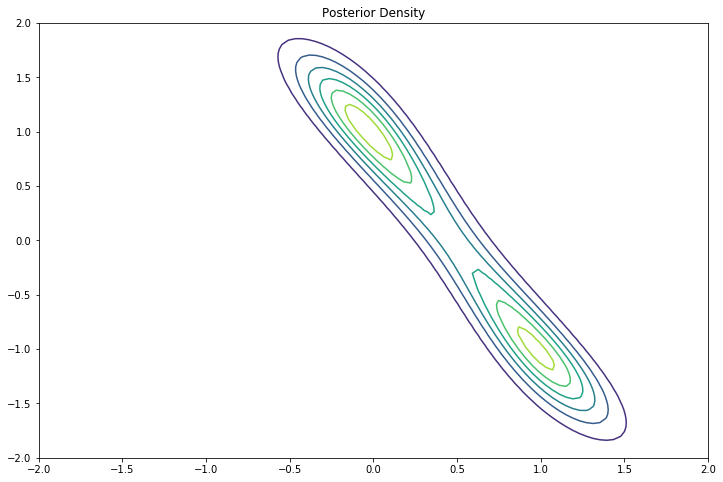

In [3]:
## Example for Mixture of Gaussian
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
sigma_1 = np.sqrt(10)
sigma_2 = np.sqrt(1)
sigma_x = np.sqrt(2)
theta_1 = 0
theta_2 = 1
np.random.seed(2)
N=100
x_points = np.zeros((N, 2))
x_points[:,0] = np.random.normal(theta_1, sigma_x, N)
x_points[:,1] = np.random.normal(theta_1+theta_2,sigma_x,N)
ind = np.random.binomial(1, 0.5, N)
x_val = np.array([x_points[k,ind[k]] for k in range(ind.shape[0])])

def unnorm_post(theta1, theta2, x = x_val, sigma_x = sigma_x, sigma_1 = sigma_1, sigma_2=sigma_2):
  
  x = np.reshape(x, (x.shape[0], 1))
  
  z_store = np.zeros((theta1.shape[0], theta2.shape[0]))
  
  for theta1idx in range(theta1.shape[0]):
    
    matr1 = theta1[theta1idx]*np.ones((x.shape[0], theta1.shape[0]))
    
    matr2 = matr1 + np.stack([theta2 for k in range(x.shape[0])])
    likelihood = np.sum(np.log(0.5*norm.pdf(x, matr1, sigma_x) + 0.5*norm.pdf(x,matr2,sigma_x)), 0)
    prior = np.log(norm.pdf(matr1[0,:], 0, sigma_1)) + np.log(norm.pdf(theta2, 0, sigma_2))
    z_store[theta1idx, :] = np.exp(likelihood + prior)
  return z_store


x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X,Y = np.meshgrid(x,y)
X = np.transpose(X)
Y = np.transpose(Y)
a = unnorm_post(x, y)
a = a/np.sum(a)
fig, ax = plt.subplots()

ax.contour(X, Y, a)
ax.set_title('Posterior Density')
fig.set_size_inches(12, 8, forward=True)


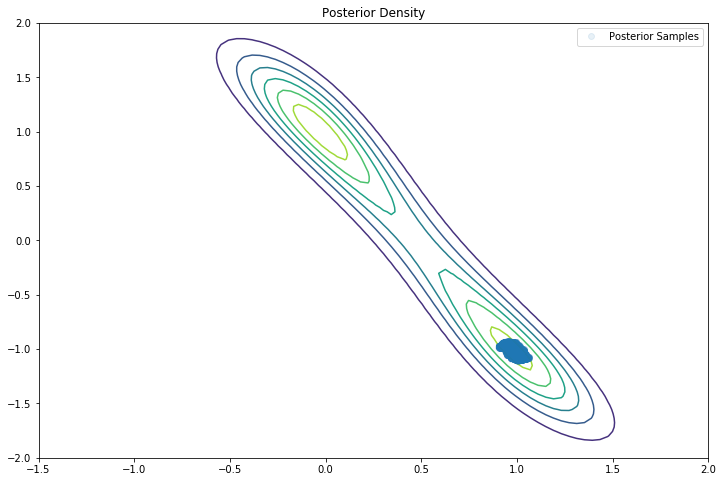

In [0]:
## Langevin Dynamics for the Mixture of Gaussian example.
from random import shuffle

def step_size(t):
  
  b=100
  a=0.2
  g=0.55
  step=a*np.power((b+t),-g)
  
  return step

def step_size2(t):
  
  k = (0.0001-0.01) / (1000000 - 1)
  m = 0.01-k*1
  step=k*t+m
  
  return step


n=1
T=300000
t1 = 1
t2 = -2

def grad_prior(theta, sigma1= sigma_1, sigma2 = sigma_2):
  
  dtheta1 = -theta[0] / sigma1**2
  dtheta2 = -theta[1] / sigma2**2
  return dtheta1, dtheta2

def grad_like(theta, x, sigma1 = sigma_1, sigma2=sigma_2, sigmax=sigma_x):
  theta1 = theta[0]
  theta2 = theta[1]
  
  ## For theta1
  p11 = 0.5*norm.pdf(x,theta1, sigma_x) + 0.5*norm.pdf(x, theta1 + theta2, sigma_x)
  p12 = -(theta1 - x) / (2*sigmax**2)*norm.pdf(x,theta1,sigmax) -(theta1+theta2-x)/(2*sigmax**2)*norm.pdf(x,theta1+theta2,sigmax)
  p13 = (N /x.shape[0]) * np.sum((1/p11) * p12)
  
  ## For theta2
  p21 = p11
  p22 = -(theta1+theta2-x)/(2*sigmax**2)*norm.pdf(x,theta1+theta2,sigmax)
  p23 = (N /x.shape[0]) * np.sum((1/p21) * p22)
  
  return p13, p23

def g(theta, x=x_val):
  
  p1 = grad_prior(theta)
  p2 = grad_like(theta, x)
  return p1[0]+p2[0], p1[1]+p2[1]

def h(theta, x):
  
  p1 = grad_prior(theta)
  p2 = grad_like(theta, x)
  return p1[0] + p2[0], p1[1] + p2[1]


minibatch_ind = [k for k in range(N)]
shuffle(minibatch_ind)



kkk=0
np.random.seed(2)
store_result = np.zeros((T,2))
for t in range(T):
  
  
  x_v = x_val[minibatch_ind[kkk]]
  x_v = np.array([x_v])
  step = step_size2(t)
  theta = np.array([t1, t2])
  h_1 = h(theta,x_v)
  
  delta_theta1 = step / 2 * (h_1[0]) + np.random.normal(0,np.sqrt(step))
  delta_theta2 = step / 2 * (h_1[1]) + np.random.normal(0,np.sqrt(step))
  
  t1 = t1 + step*delta_theta1
  t2 = t2 + step*delta_theta2
  
  
  
  store_result[t,0] = t1
  store_result[t,1] = t2
  kkk = kkk+1
  if kkk>99:
    kkk=0
  
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X,Y = np.meshgrid(x,y)

a = unnorm_post(x, y)
a = a/np.sum(a)
fig, ax = plt.subplots()
X = np.transpose(X)
Y = np.transpose(Y)

ax.contour(X, Y, a, zorder = 1)
ax.plot(store_result[200000:,0],store_result[200000:,1], linewidth = 0, marker = 'o', alpha = 0.1, zorder = 2, label = 'Posterior Samples')
ax.set_xlim(-1.5, 2)
ax.set_ylim(-2, 2)
ax.set_title('Posterior Density')
fig.set_size_inches(12, 8, forward=True)
ax.legend()


-------------------------------
As can be seen the samples are focused around one of the modes of the posterior. The Figure does not show the same results as Figure 1 in the article though but that might be due to different initilization and a different way to obtain the step-lengths. Their proposed learning rate schedule did not yield satisfactory results in this implementation.

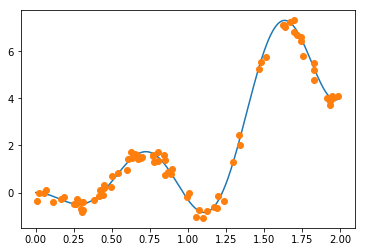

In [1]:
### For Neural network here

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data


## Generate the data
x = np.arange(0,2,0.001)
y = x**3 - x*2*np.sin(7*x) 
plt.plot(x,y)

noise_std = 0.2
N = 80 ## Had 60
x_data = np.random.uniform(0,2,N)
y_data = x_data**3 - x_data*2*np.sin(7*x_data) + np.random.normal(0, noise_std, N)
plt.plot(x_data,y_data, linewidth = 0, marker = 'o')

x_t = torch.from_numpy(x_data).view(N,1).float()
y_t = torch.from_numpy(y_data).view(N,1).float()

data_vec = torch.cat((x_t,y_t), 1)
mini_batch_size = 40

train_loader = torch.utils.data.DataLoader(data_vec, batch_size = mini_batch_size, shuffle = True)

In [2]:
import torch.nn.functional as F

class Network(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1,50)
    self.fc2 = nn.Linear(50,50)
    self.fc3 = nn.Linear(50,50)
    self.fc4 = nn.Linear(50, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

max_epoch = 20000

def lr_sched(t, max_epoch = max_epoch):
  
  k = (0.0000001-0.00005) / (max_epoch - 1)
  m = 0.00005-k*1
  step=k*t+m
  
  return step

  
torch.manual_seed(0)
np.random.seed(2)
  
my_net = Network()
loss_fn = nn.MSELoss()



def l2_loss(network):
  
  tot_loss = 0
  
  for param in network.parameters():
    tot_loss = tot_loss + (param**2).sum()
  return tot_loss


x_plot = np.arange(-2,4,0.01)
x_plot_t = torch.from_numpy(x_plot).view(x_plot.shape[0],1).float()
store_results = torch.zeros(max_epoch - int(0.9*max_epoch), x_plot.shape[0])
indk = 0

for epoch in range(max_epoch):
  
  for data in train_loader:
    
    my_net.zero_grad()
    x_val = data[:,0].view(mini_batch_size, 1)
    y_val = data[:,1].view(mini_batch_size, 1)
    
    
    out = my_net(x_val)
    loss = N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)#N*loss_fn(out, y_val) + 5e-4*l2_loss(my_net)
    loss.backward()
    
    lr = lr_sched(epoch) ## Might change later to each iteration
    #lr = 0.0000001
    for param in my_net.parameters():
      param.data = param.data - lr/2 * param.grad.data - torch.Tensor(param.data.shape).normal_(0,np.sqrt(lr))
      
  if epoch > int(0.9*max_epoch):
      with torch.no_grad():
        
        out_plot = my_net(x_plot_t).detach()
        store_results[indk,:] = out_plot[:,0]
        indk +=1
      
  
  if epoch % (max_epoch / 10) == 0 or epoch == max_epoch -1:
    print('Epoch {} Train Loss {} lr {}'.format(epoch, loss.item(), lr))



Epoch 0 Train Loss 850.2880859375 lr 5.000249512475624e-05
Epoch 2000 Train Loss 36.51799392700195 lr 4.501224561228062e-05
Epoch 4000 Train Loss 37.694671630859375 lr 4.002199609980499e-05
Epoch 6000 Train Loss 16.338470458984375 lr 3.5031746587329364e-05
Epoch 8000 Train Loss 12.464859008789062 lr 3.0041497074853744e-05
Epoch 10000 Train Loss 20.818660736083984 lr 2.505124756237812e-05
Epoch 12000 Train Loss 17.591108322143555 lr 2.0060998049902497e-05
Epoch 14000 Train Loss 19.88233757019043 lr 1.507074853742687e-05
Epoch 16000 Train Loss 17.31730842590332 lr 1.008049902495125e-05
Epoch 18000 Train Loss 14.90794563293457 lr 5.0902495124756226e-06
Epoch 19999 Train Loss 12.336102485656738 lr 1.0249512475623776e-07


No handles with labels found to put in legend.


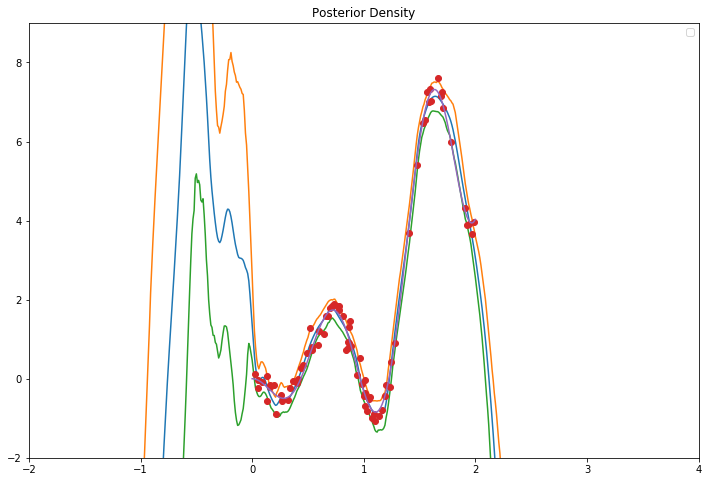

In [0]:
row_ind = [k for k in range(max_epoch - int(0.9*max_epoch)) if k % 10 == 0]
store_resultss = store_results[row_ind,:]
out_numpy = store_resultss.numpy()
out_mean = np.mean(out_numpy, 0)
out_uq = np.quantile(out_numpy, 0.9, 0)
out_lq = np.quantile(out_numpy, 0.1, 0)
fig, ax = plt.subplots()

ax.plot(x_plot,out_mean)
ax.plot(x_plot,out_uq)
ax.plot(x_plot,out_lq)

ax.plot(x_data,y_data, linewidth = 0, marker = 'o')
ax.plot(x,y)
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 9)
#ax.set_title('Posterior Density')
fig.set_size_inches(12, 8, forward=True)
ax.legend()

In [0]:
len(row_ind)

200